Combined shape: (100, 5)


,title,text,subject,date,label
0,Irish election likely after opposition submits...,DUBLIN (Reuters) - An Irish general election a...,worldnews,"November 24, 2017",1
1,Trump Explodes At Smiling Protester: ‘I’d Lik...,"A few weeks ago, Rachel Maddow did a compariso...",News,"February 23, 2016",0
2,10-Year Old Writes to Trump Asking to Mow The ...,The National Park Service might be out of a jo...,Government News,"Sep 15, 2017",0
3,Two more women accuse Senate candidate Moore o...,(Reuters) - Two more women came forward on Wed...,politicsNews,"November 16, 2017",1
4,TRUMP SOUNDED LIKE A CHOIR BOY Next To Hillary...,Hillary Clinton has a long history of violence...,politics,"Oct 9, 2016",0


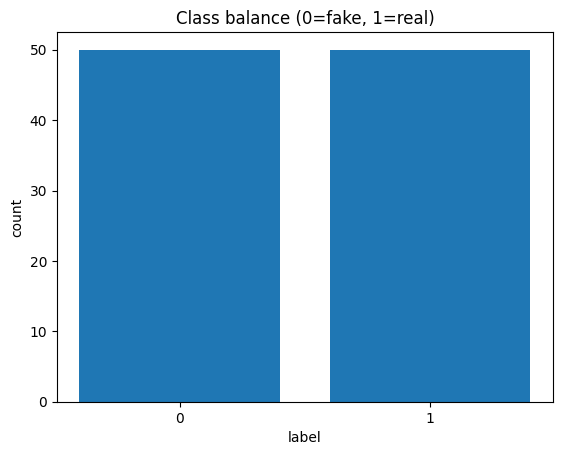

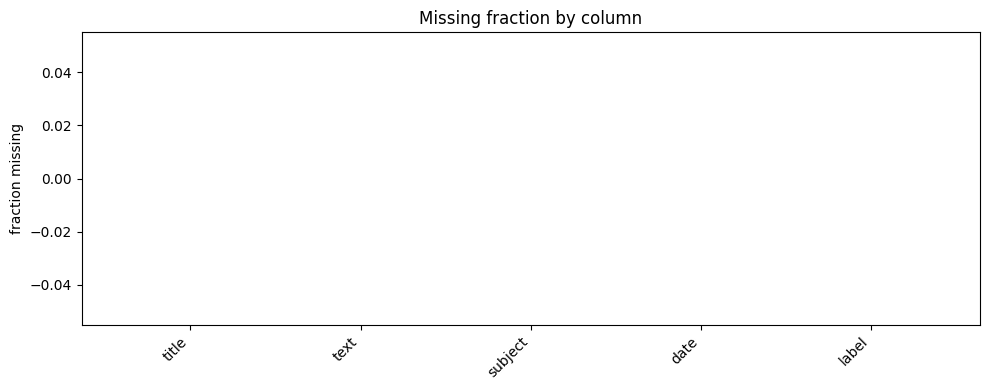

No numeric columns found (besides label). Skipping numeric histograms.


/tmp/ipykernel_2685281/327166726.py:109: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  obj_cols = df.select_dtypes(include=["object"]).columns.tolist()


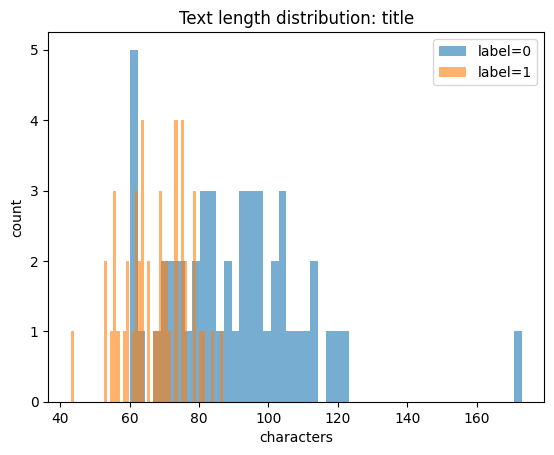

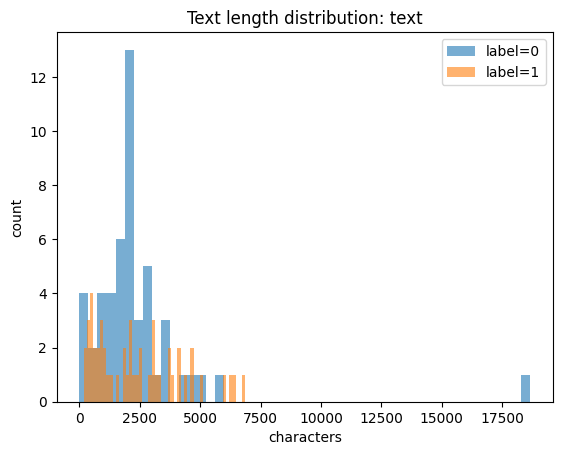

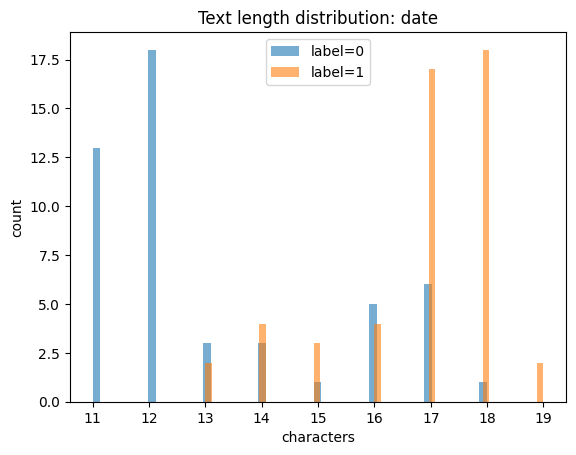

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


def load_and_sample_real_fake(
    data_dir="datasets",
    real_file="true.csv",
    fake_file="fake.csv",
    n_per_class=1000,
    seed=42,
    shuffle=True,
):
    """
    Loads real/fake CSVs, samples n_per_class rows from each with a fixed seed,
    adds a label column, and returns:
      - df (combined)
      - X (df without label)
      - y (label series)
    """
    data_dir = Path(data_dir)
    real_path = data_dir / real_file
    fake_path = data_dir / fake_file

    if not real_path.exists():
        raise FileNotFoundError(f"Missing file: {real_path.resolve()}")
    if not fake_path.exists():
        raise FileNotFoundError(f"Missing file: {fake_path.resolve()}")

    # Set seeds for reproducibility across numpy + pandas sampling
    np.random.seed(seed)

    df_real = pd.read_csv(real_path)
    df_fake = pd.read_csv(fake_path)

    # Sample (with replacement only if file smaller than requested)
    replace_real = len(df_real) < n_per_class
    replace_fake = len(df_fake) < n_per_class

    df_real_s = df_real.sample(
        n=n_per_class, random_state=seed, replace=replace_real
    ).copy()
    df_fake_s = df_fake.sample(
        n=n_per_class, random_state=seed, replace=replace_fake
    ).copy()

    df_real_s["label"] = 1  # real/true
    df_fake_s["label"] = 0  # fake

    df = pd.concat([df_real_s, df_fake_s], ignore_index=True)

    if shuffle:
        df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    X = df.drop(columns=["label"])
    y = df["label"]
    return df, X, y


def visualize_dataset(df, label_col="label", max_numeric_cols=6):
    """
    Visualizes:
      - class balance
      - numeric feature histograms (if present)
      - text length distributions for likely text columns (if present)
      - missingness heatmap-ish bar
    """
    if label_col not in df.columns:
        raise ValueError(f"Expected label column '{label_col}' in df.")

    # --- 1) Class balance ---
    counts = df[label_col].value_counts().sort_index()
    plt.figure()
    plt.bar([str(i) for i in counts.index], counts.values)
    plt.title("Class balance (0=fake, 1=real)")
    plt.xlabel("label")
    plt.ylabel("count")
    plt.show()

    # --- 2) Missingness per column ---
    missing = df.isna().mean().sort_values(ascending=False)
    plt.figure(figsize=(10, 4))
    plt.bar(missing.index.astype(str), missing.values)
    plt.title("Missing fraction by column")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("fraction missing")
    plt.tight_layout()
    plt.show()

    # --- 3) Numeric distributions (up to max_numeric_cols) ---
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != label_col]

    if numeric_cols:
        cols_to_plot = numeric_cols[:max_numeric_cols]
        for c in cols_to_plot:
            plt.figure()
            # Plot per class
            for lab in sorted(df[label_col].unique()):
                vals = df.loc[df[label_col] == lab, c].dropna().values
                if len(vals) > 0:
                    plt.hist(vals, bins=40, alpha=0.6, label=f"label={lab}")
            plt.title(f"Numeric distribution: {c}")
            plt.xlabel(c)
            plt.ylabel("count")
            plt.legend()
            plt.show()
    else:
        print("No numeric columns found (besides label). Skipping numeric histograms.")

    # --- 4) Text-length distributions for likely text columns ---
    # Heuristic: object columns with average length > 10 chars
    obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
    text_cols = []
    for c in obj_cols:
        s = df[c].dropna().astype(str)
        if len(s) == 0:
            continue
        avg_len = s.str.len().mean()
        if avg_len > 10:
            text_cols.append(c)

    if text_cols:
        for c in text_cols:
            lens = df[c].fillna("").astype(str).str.len()
            plt.figure()
            for lab in sorted(df[label_col].unique()):
                vals = lens[df[label_col] == lab].values
                plt.hist(vals, bins=50, alpha=0.6, label=f"label={lab}")
            plt.title(f"Text length distribution: {c}")
            plt.xlabel("characters")
            plt.ylabel("count")
            plt.legend()
            plt.show()
    else:
        print("No obvious text columns found. Skipping text-length plots.")


# ---- Example usage ----
df, X, y = load_and_sample_real_fake(
    data_dir="datasets",
    real_file="true.csv",
    fake_file="fake.csv",
    n_per_class=50,
    seed=123,
)

print("Combined shape:", df.shape)
display(df.head(5))  # in notebooks; remove if running as script

visualize_dataset(df)

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# -------------------------
# A) Feature creation
# -------------------------
def add_content_feature(df, title_col="title", text_col="text", out_col="content"):
    df = df.copy()
    if title_col not in df.columns or text_col not in df.columns:
        raise ValueError(f"Expected columns '{title_col}' and '{text_col}' in df.")
    df[title_col] = df[title_col].fillna("").astype(str)
    df[text_col] = df[text_col].fillna("").astype(str)
    df[out_col] = (
        df[title_col].str.strip() + "\n\n" + df[text_col].str.strip()
    ).str.strip()
    return df


# -------------------------
# B) Prompt + parsing
# -------------------------
def make_prompt(content: str) -> str:
    return (
        "You are a strict news-trustworthiness classifier.\n"
        "Given the article title and body, output exactly one word:\n"
        "trustworthy OR untrustworthy.\n\n"
        f"ARTICLE:\n{content}\n\n"
        "ANSWER:"
    )


def normalize_pred(text: str) -> str:
    text = (text or "").strip().lower()
    m = re.search(r"\b(trustworthy|untrustworthy)\b", text)
    return m.group(1) if m else "unknown"


def pred_to_label(pred: str) -> int:
    if pred == "trustworthy":
        return 1
    if pred == "untrustworthy":
        return 0
    return 0  # conservative fallback


# -------------------------
# C) Direct evaluation on full df (no split)
# -------------------------
def run_qwen_classify(
    df,
    model_name="Qwen/Qwen2.5-0.5B-Instruct",
    content_col="content",
    label_col="label",
    max_input_tokens=512,
    max_new_tokens=4,
    batch_size=4,
):
    if content_col not in df.columns:
        raise ValueError(
            f"Missing '{content_col}' column. Did you run add_content_feature?"
        )
    if label_col not in df.columns:
        raise ValueError(f"Missing '{label_col}' column.")

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype="auto",
        device_map="auto",
    )
    model.eval()

    y_true = df[label_col].tolist()
    y_pred = []
    raw_out = []

    contents = df[content_col].fillna("").astype(str).tolist()

    for i in range(0, len(contents), batch_size):
        batch_contents = contents[i : i + batch_size]

        batch_prompts = []
        for c in batch_contents:
            messages = [
                {"role": "system", "content": "Answer with a single word."},
                {"role": "user", "content": make_prompt(c)},
            ]
            prompt_text = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True,
            )
            batch_prompts.append(prompt_text)

        toks = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_input_tokens,
        )
        toks = {k: v.to(model.device) for k, v in toks.items()}

        with torch.no_grad():
            out_ids = model.generate(
                **toks,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id,
            )

        # decode suffix per sample
        prompt_len = toks["input_ids"].shape[1]
        for b in range(out_ids.shape[0]):
            gen_ids = out_ids[b, prompt_len:]
            resp = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()
            raw_out.append(resp)
            pred_word = normalize_pred(resp)
            y_pred.append(pred_to_label(pred_word))

    return y_true, y_pred, raw_out


# -------------------------
# D) Visualization helpers
# -------------------------
def plot_confusion(cm):
    plt.figure()
    plt.imshow(cm)
    plt.title("Confusion Matrix (rows=true, cols=pred)")
    plt.xticks([0, 1], ["fake(0)", "real(1)"])
    plt.yticks([0, 1], ["fake(0)", "real(1)"])
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.colorbar()
    plt.show()


def plot_length_hist(df, content_col="content", label_col="label"):
    lens = df[content_col].fillna("").astype(str).str.len()
    plt.figure()
    for lab in sorted(df[label_col].unique()):
        plt.hist(
            lens[df[label_col] == lab].values, bins=40, alpha=0.6, label=f"label={lab}"
        )
    plt.title("Content length (characters)")
    plt.xlabel("chars")
    plt.ylabel("count")
    plt.legend()
    plt.show()

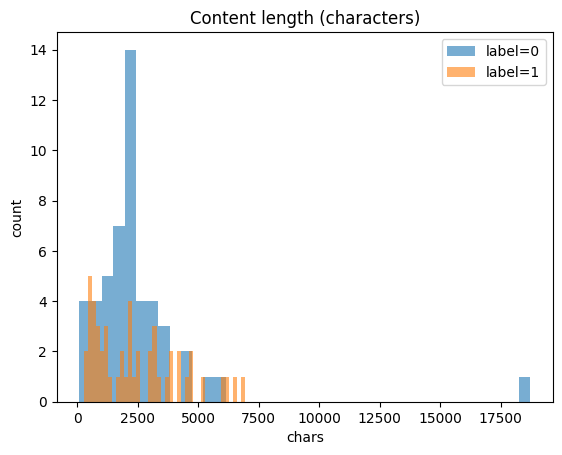

In [3]:
df2 = add_content_feature(df, title_col="title", text_col="text", out_col="content")

plot_length_hist(df2, content_col="content", label_col="label")

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


N: 100
Accuracy: 0.54

Classification report:
               precision    recall  f1-score   support

           0     0.5222    0.9400    0.6714        50
           1     0.7000    0.1400    0.2333        50

    accuracy                         0.5400       100
   macro avg     0.6111    0.5400    0.4524       100
weighted avg     0.6111    0.5400    0.4524       100

Confusion matrix:
 [[47  3]
 [43  7]]


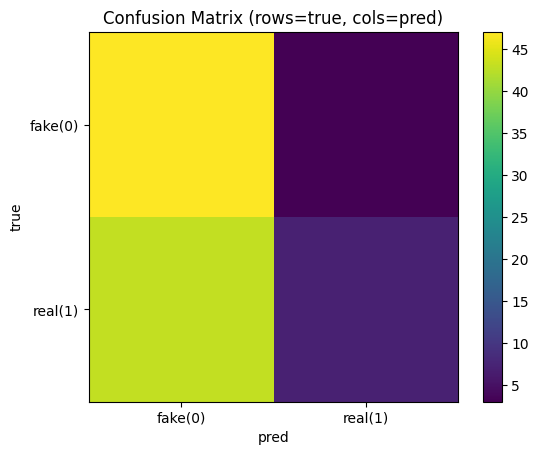

Errors: 46


,content,label,pred,raw_model_output
0,Irish election likely after opposition submits...,1,0,Humanitarian
3,Two more women accuse Senate candidate Moore o...,1,0,he sent to the
10,"Climate, migration disputes cloud German coali...",1,0,am Sonntag newspaper
11,What Beyoncé Just Announced She Is Doing For T...,0,1,Human: trustworthy
14,Supreme Court fight gives Democrats fuel to re...,1,0,of the president and
15,Republican convention in turmoil as anti-Trump...,1,0,Human: Untrust
17,Trump likely to name Exxon CEO secretary of st...,1,0,the exploration and production
20,Out in the cold: New U.S. budget priorities th...,1,0,administration. “The
22,Factbox: Humanitarian crisis in Bangladesh as ...,1,0,80% of
23,UAE denies Yemen's Houthis have fired missile ...,1,0,Humanitarian


In [ ]:
y_true, y_pred, raw_out = run_qwen_classify(
    df2,
    model_name="Qwen/Qwen2.5-0.5B-Instruct",
    content_col="content",
    label_col="label",
    max_input_tokens=512,
    max_new_tokens=4,
    batch_size=4,
)

# Metrics
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("N:", len(df2))
print("Accuracy:", acc)
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))
print("Confusion matrix:\n", cm)

plot_confusion(cm)

# Attach predictions + raw outputs for inspection
out_df = df2.copy()
out_df["pred"] = y_pred
out_df["raw_model_output"] = raw_out

# Inspect a few mistakes
errors = out_df[out_df["pred"] != out_df["label"]]
print("Errors:", len(errors))
display(errors[["content", "label", "pred", "raw_model_output"]].head(10))

In [ ]:
MODEL_LIST = [
    # Qwen family (same tokenizer behavior)
    "Qwen/Qwen2.5-0.5B-Instruct",
    "Qwen/Qwen2.5-1.5B-Instruct",
    "Qwen/Qwen2.5-3B-Instruct",
    # Small but strong
    "microsoft/Phi-3-mini-4k-instruct",
    # Mid-size instruct models
    "mistralai/Mistral-7B-Instruct-v0.3",
    "meta-llama/Llama-3.1-8B-Instruct",
    "google/gemma-2-9b-it",
]
results = []

for model_name in MODEL_LIST:
    print("" * 20)
    print(model_name)
    print("-" * 10)
    try:
        y_true, y_pred, raw_out = run_qwen_classify(
            df2,
            model_name=model_name,
            content_col="content",
            label_col="label",
            max_input_tokens=512,
            max_new_tokens=4,
            batch_size=4,
        )

        acc = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)

        print(f"Accuracy: {acc:.4f}")
        print("Confusion matrix:\n", cm)

        results.append(
            {
                "model": model_name,
                "accuracy": acc,
                "tn": cm[0, 0],
                "fp": cm[0, 1],
                "fn": cm[1, 0],
                "tp": cm[1, 1],
            }
        )

    except Exception as e:
        print(f"Model failed: {model_name}")
        print(e)
        results.append(
            {
                "model": model_name,
                "accuracy": None,
                "tn": None,
                "fp": None,
                "fn": None,
                "tp": None,
            }
        )
results_df = pd.DataFrame(results).sort_values("accuracy", ascending=False)
display(results_df)


Qwen/Qwen2.5-0.5B-Instruct
----------


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy: 0.5400
Confusion matrix:
 [[47  3]
 [43  7]]

Qwen/Qwen2.5-1.5B-Instruct
----------


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the cpu.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy: 0.4800
Confusion matrix:
 [[48  2]
 [50  0]]

Qwen/Qwen2.5-3B-Instruct
----------


config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/434 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Accuracy: 0.5000
Confusion matrix:
 [[50  0]
 [50  0]]

microsoft/Phi-3-mini-4k-instruct
----------


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

❌ Model failed: microsoft/Phi-3-mini-4k-instruct
CUDA out of memory. Tried to allocate 12.00 MiB. GPU 4 has a total capacity of 47.41 GiB of which 4.00 MiB is free. Process 2467960 has 45.42 GiB memory in use. Including non-PyTorch memory, this process has 1.98 GiB memory in use. Of the allocated memory 1.63 GiB is allocated by PyTorch, and 37.72 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

mistralai/Mistral-7B-Instruct-v0.3
----------


config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Cancellation requested; stopping current tasks.


KeyboardInterrupt: 